In [1]:
from pathlib import Path
import os
import pandas as pd
from psifr import fr
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn.linear_model as lm
from cymr import network
from cymr import cmr

from dcmr import task
from dcmr import framework

cfr_dir = Path(os.environ['CFR_RESULTS'])
fit_dir = Path(os.environ['CFR_FITS']).parent / 'v7'

data_file = cfr_dir / 'cfr_data.csv'
patterns_file = cfr_dir / 'cfr_patterns.hdf5'

In [2]:
data = task.read_free_recall(data_file)
patterns = cmr.load_patterns(patterns_file)

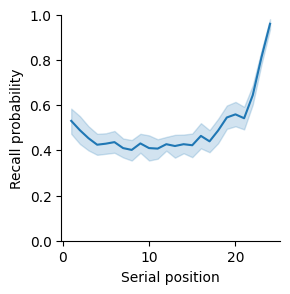

In [3]:
fr.plot_spc(fr.spc(data))

In [4]:
models = [
    'simple/cmrst_fea-loc-cat-use_sem-context_cue-focused', 
    'switchboard4/cmrsit_sem-split_cue-focused_dis-cat_sub-list', 
    'switchboard4/cmrsit_sem-item_sub-list',
]
model_names = ['DCMR-Focused', 'DCMR-Disrupt', 'CMR-MP16']
full = framework.read_model_sims(data_file, fit_dir, models, model_names, block=True)

In [5]:
cat_block_crp = full.groupby('source').apply(task.category_crp_block_pos, include_groups=False)

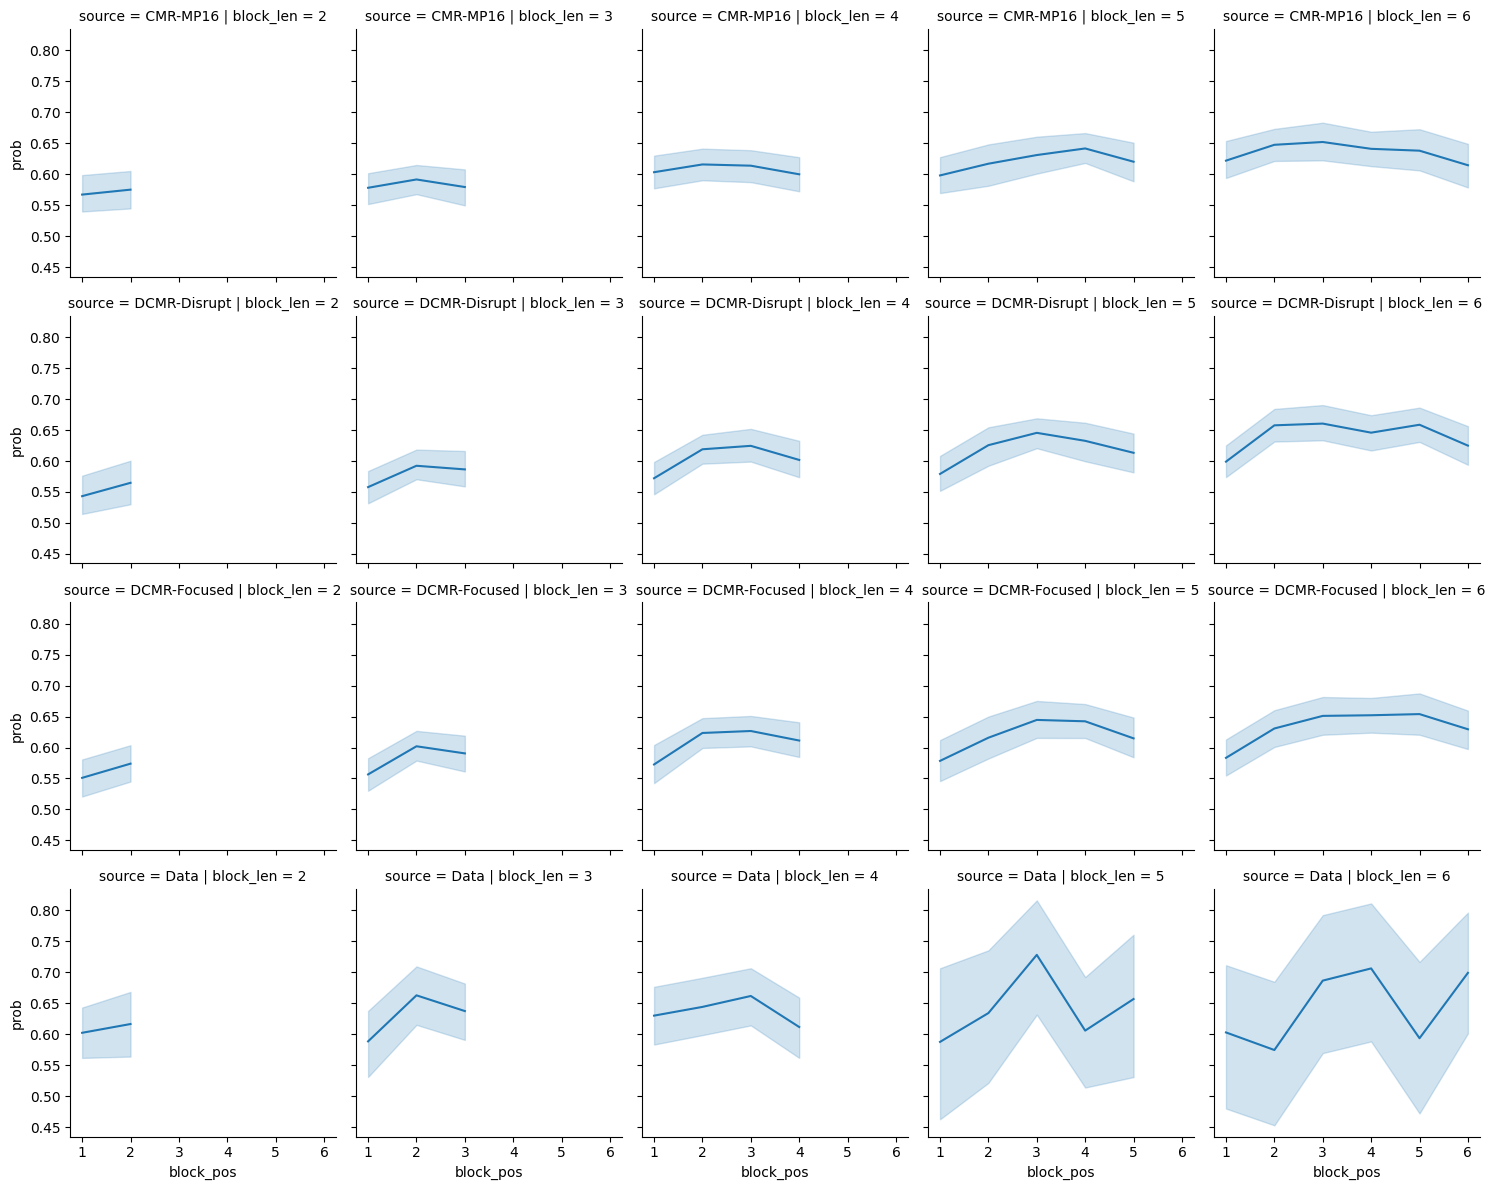

In [6]:
sns.relplot(
    cat_block_crp, x='block_pos', y='prob', row='source', col='block_len', kind='line', height=3
);

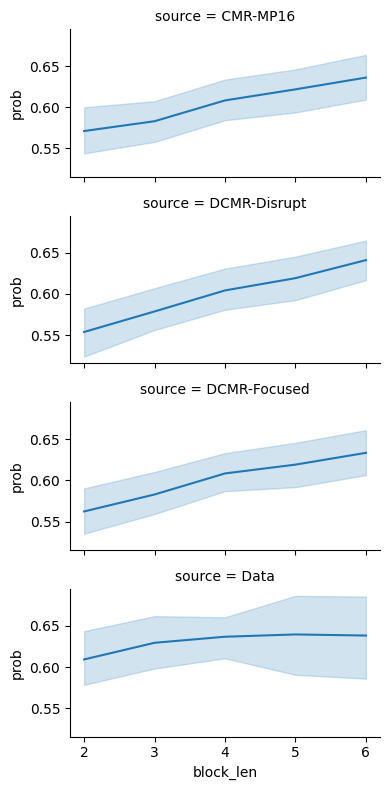

In [7]:
m = cat_block_crp.groupby(['source', 'subject', 'block_len'])['prob'].mean().reset_index()
sns.relplot(m, x='block_len', y='prob', row='source', kind='line', aspect=2, height=2);

In [8]:
res_pos = cat_block_crp.query('block_pos <= 3').groupby(['source', 'subject', 'block_len']).apply(
    task.crp_regress_block_pos, include_groups=False
)
res_pos.name = "slope"

In [9]:
res_neg = cat_block_crp.query('block_pos >= -3').groupby(['source', 'subject', 'block_len']).apply(
    task.crp_regress_block_pos, include_groups=False
)
res_neg.name = "slope"

In [10]:
res_comb = pd.concat([res_pos, res_neg], axis=0, keys=['pos', 'neg'])
res_comb = res_comb.reset_index()
res_comb = res_comb.rename(columns={'level_0': 'direction'})

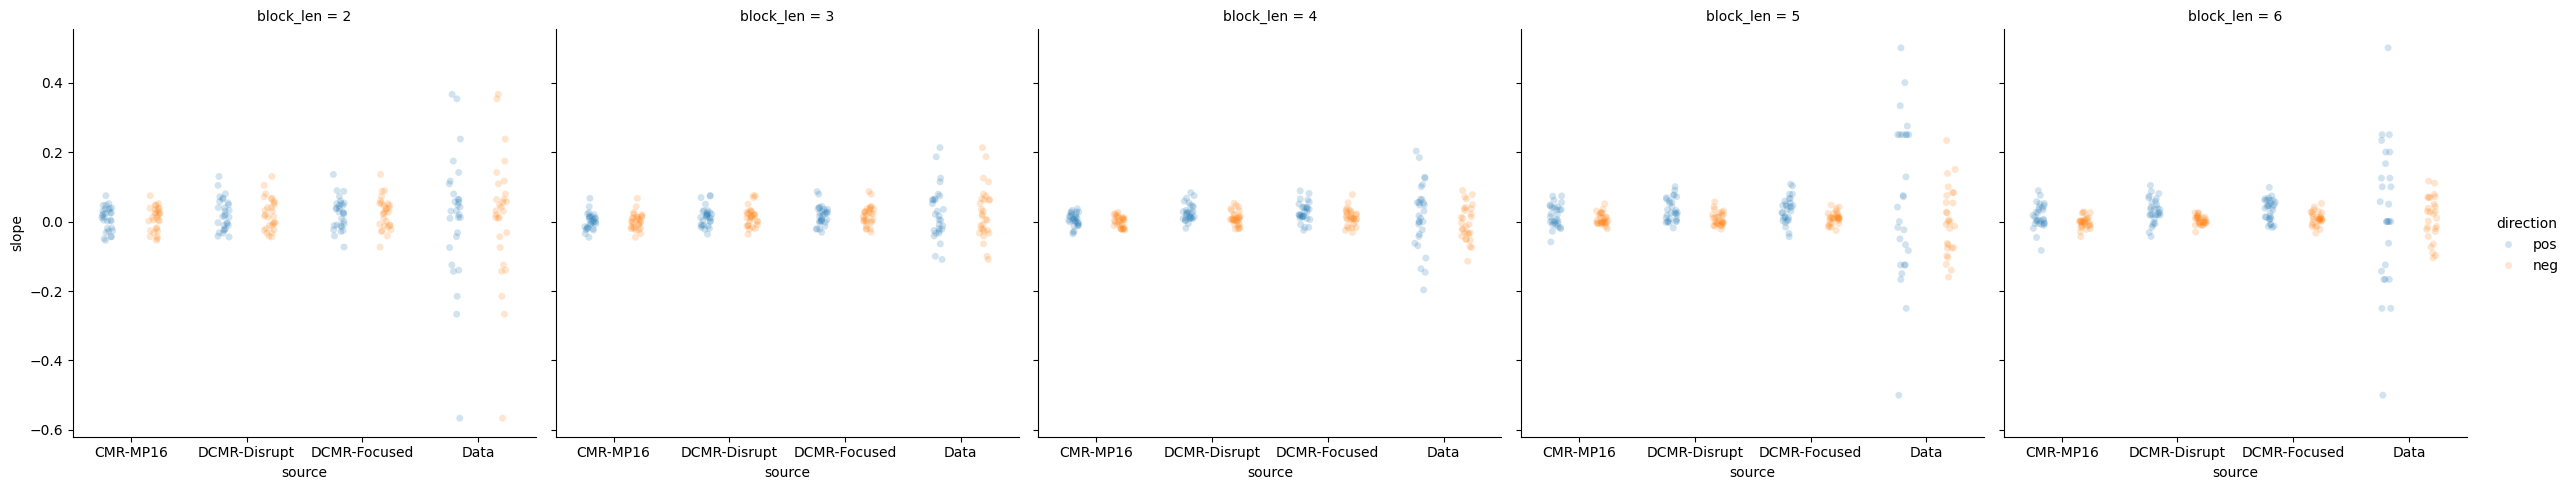

In [11]:
sns.catplot(res_comb, x='source', y='slope', hue='direction', dodge=True, alpha=0.2, col='block_len');

In [12]:
res_diff = (res_pos - res_neg).reset_index()
res_diff

,source,subject,block_len,slope
0,CMR-MP16,1,2,0.000000
1,CMR-MP16,1,3,0.000000
2,CMR-MP16,1,4,0.001455
3,CMR-MP16,1,5,0.048632
4,CMR-MP16,1,6,0.039116
...,...,...,...,...
575,Data,46,2,0.000000
576,Data,46,3,0.000000
577,Data,46,4,0.010834
578,Data,46,5,0.196667


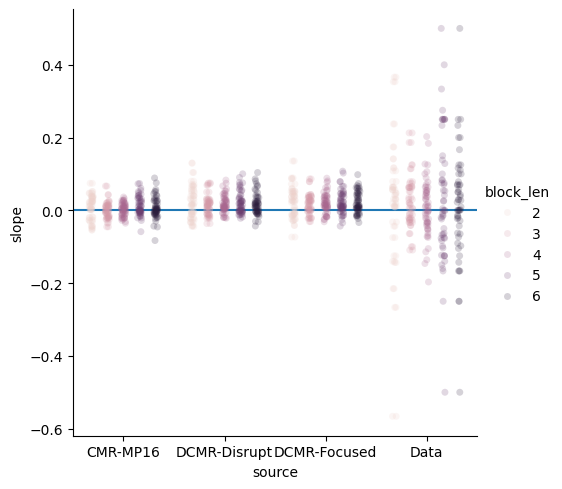

In [13]:
sns.catplot(res_comb, x='source', y='slope', dodge=True, alpha=0.2, hue='block_len');
plt.axhline(0, *plt.gca().get_xlim())

In [14]:
res_pos = cat_block_crp.query('block_pos <= 3').groupby(['source', 'subject', 'block_len']).apply(
    task.crp_regress_block_pos, include_groups=False
)
res_pos.name = "slope"
res_pos = res_pos.reset_index()

In [15]:
m_pos = res_pos.query('block_len > 2').groupby(['source', 'subject'])['slope'].mean().unstack('source')
m_pos.agg(['mean', 'sem'])

source,CMR-MP16,DCMR-Disrupt,DCMR-Focused,Data
mean,0.009343,0.026095,0.027731,0.027645
sem,0.003394,0.004586,0.004683,0.016021


In [16]:
for source in m_pos.columns:
    print(source)
    print(pg.ttest(m_pos[source], 0, alternative='greater'))

CMR-MP16
               T  dof alternative    p-val       CI95%   cohen-d   BF10  \
T-test  2.752582   28     greater  0.00513  [0.0, inf]  0.511142  8.914   

           power  
T-test  0.850887  
DCMR-Disrupt
               T  dof alternative     p-val        CI95%   cohen-d      BF10  \
T-test  5.689485   28     greater  0.000002  [0.02, inf]  1.056511  9341.833   

           power  
T-test  0.999952  
DCMR-Focused
               T  dof alternative     p-val        CI95%   cohen-d       BF10  \
T-test  5.921092   28     greater  0.000001  [0.02, inf]  1.099519  1.663e+04   

           power  
T-test  0.999982  
Data
               T  dof alternative     p-val       CI95%  cohen-d   BF10  \
T-test  1.725514   28     greater  0.047729  [0.0, inf]  0.32042  1.467   

           power  
T-test  0.515464  


In [17]:
res_neg = cat_block_crp.query('block_pos >= -3').groupby(['source', 'subject', 'block_len']).apply(
    task.crp_regress_block_pos, include_groups=False
)
res_neg.name = "slope"
res_neg = res_neg.reset_index()

In [18]:
m_neg = res_neg.query('block_len > 2').groupby(['source', 'subject'])['slope'].mean().unstack('source')
m_neg.agg(['mean', 'sem'])

source,CMR-MP16,DCMR-Disrupt,DCMR-Focused,Data
mean,0.001025,0.008653,0.011852,0.006812
sem,0.002559,0.003233,0.003688,0.007247


In [19]:
for source in m_neg.columns:
    print(source)
    print(pg.ttest(m_neg[source], 0, alternative='less'))

CMR-MP16
               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  0.400384   28        less  0.654044  [-inf, 0.01]  0.074349  0.425   

           power  
T-test  0.020889  
DCMR-Disrupt
               T  dof alternative     p-val         CI95%  cohen-d   BF10  \
T-test  2.676372   28        less  0.993851  [-inf, 0.01]  0.49699  0.131   

          power  
T-test  0.00001  
DCMR-Focused
               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  3.213471   28        less  0.998355  [-inf, 0.02]  0.596727  0.042   

               power  
T-test  8.591636e-07  
Data
               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  0.939975   28        less  0.822365  [-inf, 0.02]  0.174549  0.591   

           power  
T-test  0.005195  


In [20]:
for source in m_neg.columns:
    print(source)
    print(pg.ttest(m_pos[source], m_neg[source], alternative='greater'))

CMR-MP16
               T  dof alternative     p-val       CI95%   cohen-d   BF10  \
T-test  1.956814   56     greater  0.027681  [0.0, inf]  0.513884  2.576   

           power  
T-test  0.613417  
DCMR-Disrupt
               T  dof alternative     p-val        CI95%   cohen-d    BF10  \
T-test  3.108093   56     greater  0.001479  [0.01, inf]  0.816225  25.247   

           power  
T-test  0.922972  
DCMR-Focused
              T  dof alternative     p-val        CI95%   cohen-d   BF10  \
T-test  2.66362   56     greater  0.005038  [0.01, inf]  0.699501  9.415   

           power  
T-test  0.838022  
Data
               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  1.184757   56     greater  0.120559  [-0.01, inf]  0.311132  0.955   

           power  
T-test  0.317605  


In [21]:
data.groupby('block_pos')['block_pos'].count()

block_pos
1    6557
2    6582
3    4208
4    2428
5     854
6     430
Name: block_pos, dtype: int64[pyarrow]

In [22]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 9.2.0

pingouin  : 0.5.5
dcmr      : 1.0.0a0
numpy     : 2.1.3
seaborn   : 0.13.2
platform  : 1.0.8
psifr     : 0.10.1
matplotlib: 3.10.3
sys       : 3.12.8 (main, Jan 22 2025, 16:41:29) [Clang 16.0.0 (clang-1600.0.26.3)]
cymr      : 0.13.0
pandas    : 2.2.3
sklearn   : 1.6.1

